In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def sine_with_trend(num=1000, a=1):
    x = np.linspace(0, 100, num=num)
    return 10 * np.sin(x) + a * x

,val
2010-10-11,0.000000
2010-10-25,7.145205
2010-11-08,11.256386
2010-11-22,10.727836
2010-12-06,6.138081


,val
2010-10-31,3.572602
2010-11-30,10.992111
2010-12-31,3.057805
2011-01-31,-3.376508
2011-02-28,10.051264


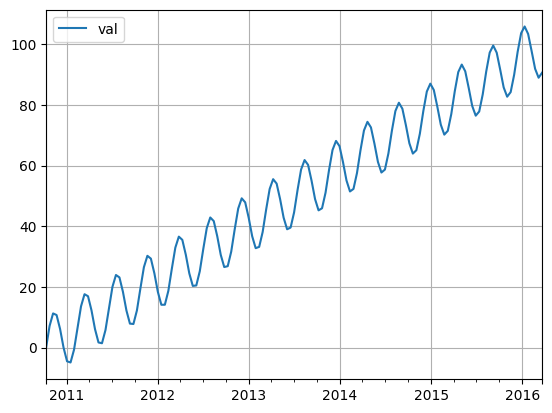

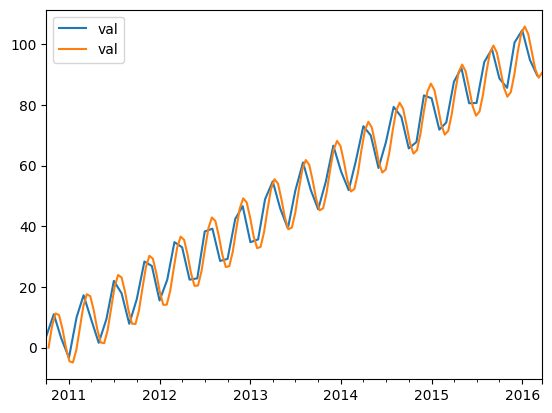

<AxesSubplot: >

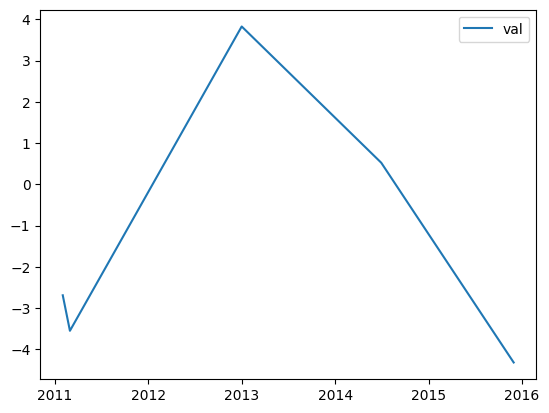

In [3]:
import datetime

x_days = 14
vals = sine_with_trend(num=2000)
dt_start = datetime.datetime(2010, 10, 11)
dt_end = dt_start + datetime.timedelta(days=len(vals) - 1)
vals = vals[::x_days]
idx = pd.date_range(dt_start, dt_end, freq=f"{x_days}D")
df = pd.DataFrame(vals, index=idx, columns=["val"])
df.plot()
plt.grid()
display(df.head())

df_resample_1M = df.resample("M").mean()
display(df_resample_1M.head())
ax = df_resample_1M.plot()# sns.lineplot(data=df_resample_1D)
df.plot(ax=ax, label="val_original")# sns.lineplot(data=df, )
ax.legend()
plt.show()

sns.lineplot(data=df_resample_1M - df)

In [4]:
df = pd.read_csv(
    "CTA_-_Ridership_-_Daily_Boarding_Totals.csv",
    names=["date", "day_type", "bus", "rail", "total"],
    header=1,
    parse_dates=["date"]
)
df = df.drop("total", axis=1)

df = df.sort_values(by="date").set_index("date")
display(df.shape)
df = df.drop_duplicates()
display(df.shape)
display(df.head())

rail_results = {}

(8035, 3)

(7973, 3)

,day_type,bus,rail
date,,,
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
2001-01-06,A,577401,255356


### Predict by naive pasting values from previous week

date
2019-05-23    W
2019-05-24    W
2019-05-25    A
2019-05-26    U
2019-05-27    U
2019-05-28    W
2019-05-29    W
2019-05-30    W
Name: day_type, dtype: object

'MAE:'

bus     43915.608696
rail    42143.271739
dtype: float64

'MAPE:'

'bus     8.293847\nrail    8.994765\ndtype: float64%'

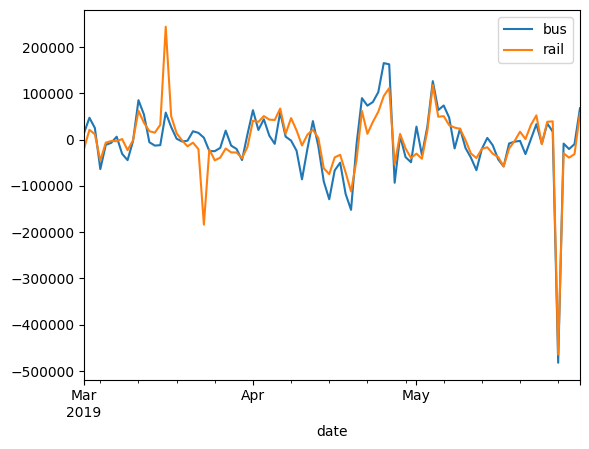

In [5]:
df_diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]
df_diff_7.plot()
display(df.loc["2019-05-23":"2019-05-30"]["day_type"])  # <---- long weekend because of holiday on friday 25th
mae = df_diff_7.abs().mean()
display("MAE:")
display(mae)
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
display("MAPE:")
mape = (df_diff_7.abs() / targets).mean() * 100
display(f"{mape}%")

rail_results["naive_pasting"] = {
    "mae": mae,
    "mape": mape
}

<AxesSubplot: xlabel='date'>

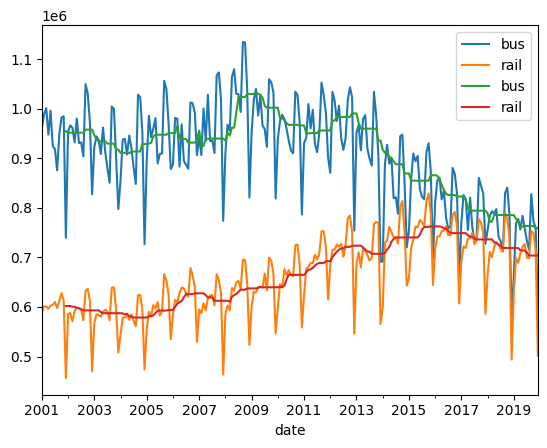

In [6]:
period = slice("2001", "2019")
df_rolling_1M_resample_median = df[period].resample("1M").median(numeric_only=True)
df_rolling_1M_resample_median_12M_median = df_rolling_1M_resample_median.rolling(window=12).median()
df_rolling_30_days_median = df[period].rolling(window=30).median(numeric_only=True)
ax = df_rolling_1M_resample_median.plot()
df_rolling_1M_resample_median_12M_median.plot(ax=ax)

In [7]:
df_tmp = pd.DataFrame.from_dict(
    {
        "a": [1, 2, 2, 5]
    }
)
df_tmp["diff_1"] = df_tmp["a"].diff(1)
df_tmp["diff_2"] = df_tmp["a"].diff(2)
df_tmp.head()

,a,diff_1,diff_2
0,1,NaN,NaN
1,2,1.0,NaN
2,2,0.0,1.0
3,5,3.0,3.0


### Both seasonality (yearly "peaks" and periods) and trends removed (bus downtrend, rail uprtrend)

<AxesSubplot: xlabel='date'>

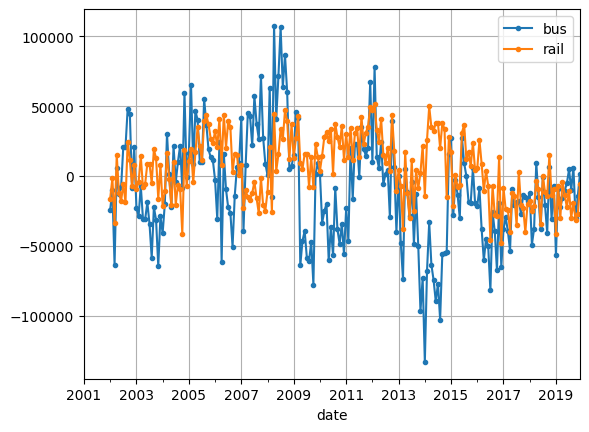

In [8]:
df_monthly_mean = df.resample("1M").mean(numeric_only=True)
df_rolling_1M_resample_median_diff_12M = df_rolling_1M_resample_median.diff(12)
df_monthly_mean_diff_1Y_median = df_monthly_mean[period].diff(12)
df_monthly_mean_diff_1Y_median.plot(marker='.', grid=True)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   30
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  -0.924
Date:                Wed, 11 Jan 2023   AIC                              7.847
Time:                        15:28:31   BIC                             12.051
Sample:                             0   HQIC                             9.192
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9755      0.572      1.705      0.088      -0.146       2.097
ar.L1          0.9206      0.084     10.997      0.000       0.757       1.085
sigma2         0.0585      0.030      1.934      0.0

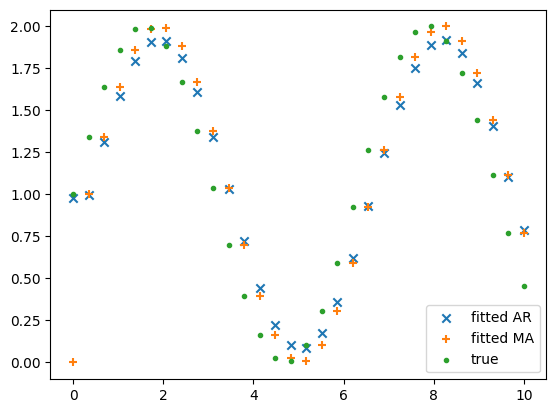

In [9]:
from statsmodels.tsa.arima.model import ARIMA


x = np.linspace(0, 10, num=30)
y = np.sin(x) + 1

p = 1
ar = ARIMA(
    endog=y,
    order=(p, 0, 0)
)

ma = ARIMA(
    endog=y,
    order=(0, 1, 0)
)

res_ar = ar.fit()
print(res_ar.summary())
plt.scatter(x, res_ar.fittedvalues, label="fitted AR", marker='x')

res_ma = ma.fit()
print(res_ma.summary())
plt.scatter(x, res_ma.fittedvalues, label="fitted MA", marker='+')

plt.scatter(x, y, label="true", marker='.')
plt.legend()

print(res_ma.forecast())
print(res_ar.forecast())


In [10]:
origin, end_date = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:end_date]["rail"].asfreq("1D")  # otherwise ARIMA produces warning

p, d, q = 1, 0, 0
P, D, Q, s = 0, 1, 1, 7
model = ARIMA(
    rail_series,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s)
)
model = model.fit()
first_forecasted = model.forecast()
first_true = df.loc[first_forecasted.index]["rail"]
percentage_relative_error = ((first_forecasted - first_true) / first_true * 100).to_numpy()
print(first_forecasted.to_numpy(), first_true.to_numpy(), f"{percentage_relative_error}%")


[427758.6262224] [379044] [12.85197133]%


### Retrain model everyday, forecast next day, see what will happen

In [11]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_range = pd.date_range(start_date, end_date)

y_preds_day_by_day = []

p, d, q = 1, 0, 0
P, D, Q, s = 0, 1, 1, 7
for today in time_range.shift(-1):
    rail_series = df.loc[origin:today]["rail"].asfreq("1D")
    model = ARIMA(
        rail_series,
        order=(p, d, q),
        seasonal_order=(P, D, Q, s)
    )
    model = model.fit()
    y_pred = model.forecast()[0]  # [0] because result is in form of array (or series when series passed to model)
    y_preds_day_by_day.append(y_pred)

In [12]:
ser = pd.Series(y_preds_day_by_day, index=time_range)

mae = ((df.loc[time_range]["rail"] - ser)).abs().mean()
mape = ((df.loc[time_range]["rail"] - ser) / df.loc[time_range]["rail"]).abs().mean() * 100
display(f"mae={round(mae, 2)}")
display(f"mape={round(mape, 2)}%")
rail_results["SARIMA_retrained_everyday"] = {
    "mae": mae,
    "mape": mape
}


'mae=32040.72'

'mape=7.54%'

'49920.969759098996, 8.092451187532511%'

'51767.77238205608, 9.317678149523884%'

'59178.80373748148, 11.155859327974188%'

<AxesSubplot: >

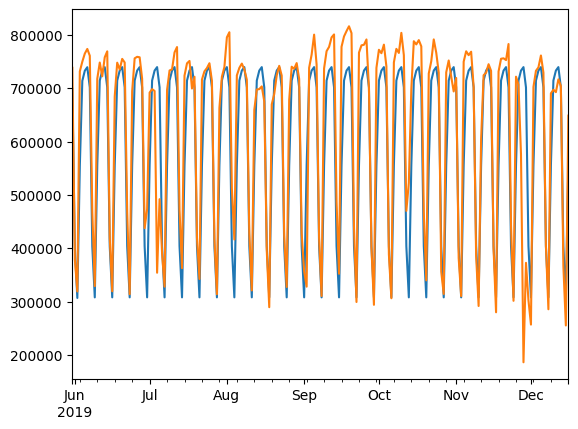

In [13]:
for num in [10, 100, 200]:
    ser = model.forecast(num)
    mae = (df.loc[ser.index]["rail"] - ser).abs().mean()
    mape = ((df.loc[ser.index]["rail"] - ser) / df.loc[ser.index]["rail"]).abs().mean() * 100
    display(f"{mae}, {mape}%")

ser.plot()
df.loc[ser.index]["rail"].plot()

In [14]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [15]:
import tensorflow as tf

In [16]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_val = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":"2019-11"] / 1e6

In [17]:
seq_length = 7 * 8  # eight weeks
bs = 32

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=bs,
    shuffle=True,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_val.to_numpy(),
    targets=rail_val.to_numpy()[seq_length:],
    sequence_length=seq_length,
    batch_size=bs,
    # shuffle=True,  # 
    # seed=42  # 
)

### MLP approach

In [18]:
models = [
    tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=(seq_length,), activation="relu"),
    tf.keras.layers.Dense(1)
    ]),
    tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_shape=(seq_length,))
    ]),
]
names = ["Dense_10_neurons", "Dense_1_neuron"]

results = []
histories = []
for model, name in zip(models, names):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.Huber(),
        metrics=["mae", "mse"]
    )

    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=50, restore_best_weights=True
    )
    history = model.fit(train_ds, validation_data=valid_ds, callbacks=[es], epochs=200, verbose=0)
    results.append(np.array(model.evaluate(valid_ds)) * 1e6)
    histories.append(history)
    rail_results[name] = {
        "history": history,
        "model": model
    }
display(results)

3/3 [==============================] - 0s 4ms/step - loss: 0.0024 - mae: 0.0405 - mse: 0.0048


[array([ 2163.31216507, 39540.07104039,  4326.62433013]),
 array([ 2383.12897272, 40538.03160787,  4766.25794545])]

### RNN approach
- Shallower is better than MLP
- Shallower is better than deep RNN

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=(None, 1))
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.Huber(),
    metrics=["mae", "mse"]
)

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=50, restore_best_weights=True
)
history = model.fit(train_ds, validation_data=valid_ds, callbacks=[es], epochs=200, verbose=0)
rail_results["SimpleRNN_1_neuron"] = {
    "history": history,
    "model": model
}
model.evaluate(valid_ds)

3/3 [==============================] - 0s 6ms/step - loss: 0.0104 - mae: 0.1077 - mse: 0.0207


[0.01037138607352972, 0.10768642276525497, 0.02074277214705944]

In [20]:
rail_results

{'naive_pasting': {'mae': bus     43915.608696
  rail    42143.271739
  dtype: float64,
  'mape': bus     8.293847
  rail    8.994765
  dtype: float64},
 'SARIMA_retrained_everyday': {'mae': 32040.720090488467,
  'mape': 7.54310072810324},
 'Dense_10_neurons': {'history': <keras.callbacks.History at 0x1dea564c070>,
  'model': <keras.engine.sequential.Sequential at 0x1deb340a860>},
 'Dense_1_neuron': {'history': <keras.callbacks.History at 0x1deb47425f0>,
  'model': <keras.engine.sequential.Sequential at 0x1deb2e06170>},
 'SimpleRNN_1_neuron': {'history': <keras.callbacks.History at 0x1deb5808d60>,
  'model': <keras.engine.sequential.Sequential at 0x1deb340a290>}}

In [27]:
mae_d_1_n = rail_results["Dense_1_neuron"]["history"].history["mae"][-1] * 1e6
mae_d_10_n = rail_results["Dense_10_neurons"]["history"].history["mae"][-1] * 1e6
mae_s_rnn_1_n = rail_results["SimpleRNN_1_neuron"]["history"].history["mae"][-1] * 1e6

display(mae_d_1_n, mae_d_10_n, mae_s_rnn_1_n)

46110.283583402634

39814.162999391556

117052.74134874344

In [30]:
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=(None, 1)),
    tf.keras.layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.Huber(),
    metrics=["mae", "mse"]
)

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=50, restore_best_weights=True
)
history = model.fit(train_ds, validation_data=valid_ds, callbacks=[es], epochs=200, verbose=0)
rail_results["SimpleRNN_32_neuron"] = {
    "history": history,
    "model": model
}
model.evaluate(valid_ds)

3/3 [==============================] - 0s 6ms/step - loss: 0.0017 - mae: 0.0315 - mse: 0.0035


[0.0017346106469631195, 0.03146573528647423, 0.003469221293926239]

In [34]:
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=(None, 1), return_sequences=True),
    tf.keras.layers.SimpleRNN(16, return_sequences=True),
    tf.keras.layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.Huber(),
    metrics=["mae", "mse"]
)

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=50, restore_best_weights=True
)
history = model.fit(train_ds, validation_data=valid_ds, callbacks=[es], epochs=200, verbose=0)
rail_results["SimpleRNN_32_16_neuron"] = {
    "history": history,
    "model": model
}
model.evaluate(valid_ds)

3/3 [==============================] - 0s 8ms/step - loss: 0.0169 - mae: 0.1339 - mse: 0.0338


[0.016909589990973473, 0.13388270139694214, 0.033819179981946945]

### Multivariate timeseries